This notebools is based on the following paper:

>**The tricellular vertex-specific adhesion molecule Sidekick facilitates polarised cell intercalation during Drosophila axis extension** _Tara M Finegan, Nathan Hervieux, Alexander Nestor-Bergmann, Alexander G. Fletcher, Guy B Blanchard, Benedicte Sanson_ bioRxiv 704932; doi: https://doi.org/10.1101/704932 

In particular, the authors expose a nice way to account for rosettes and solve topology changes in a more generic and I think robust way than T1 transition. I think, it allows vertices with more than 3 out-edges to have a finite lifetime, and avoids T1 oscillations



I explore its implementation in [tyssue](https://github.com/damcb/tyssue), in 2D (also maybe in 3D, though it's less clear how :p).

In [1]:
# % conda install -c conda-forge tyssue

In [2]:
import numpy as np
import pandas as pd
import ipyvolume as ipv

import matplotlib.pylab as plt
%matplotlib inline


from tyssue import config
from tyssue import Monolayer, Sheet
from tyssue import PlanarGeometry as geom
from tyssue.generation import extrude
from tyssue.dynamics import model_factory, effectors
from tyssue.solvers.quasistatic import QSSolver

from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split

from tyssue.draw import sheet_view, highlight_cells

from tyssue.core.sheet import get_opposite

from tyssue.generation import single_cell
from tyssue.core.objects import _is_closed_cell
from tyssue.topology import condition_4i, condition_4ii

from tyssue.utils import connectivity

### Create a small patch of cells in 2D and a simple mechanical model

In [3]:
sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.2)
to_cut = sheet.cut_out([(0.1, 6), (0.1, 6)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
sheet.update_rank()
model = model_factory(
    [
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        "contractility": 5e-2,
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "line_tension": 1e-2,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

Reseting column is_active of the vert dataset with new specs


### Gradient descent

<<<<<<< local


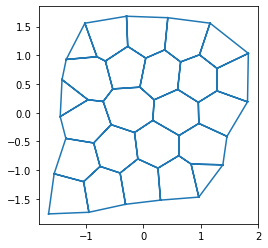

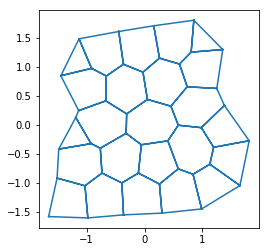

>>>>>>> remote


In [4]:
solver = QSSolver()

res = solver.find_energy_min(sheet, geom, model)

fig, ax = sheet_view(sheet, mode="quick")


## Formation of rosettes

<hr/>

![first screencap, forming rosettes](illus/finegan_etal_screencap1.png)

_Finegan et al. 2019_

In [5]:
# first let's get vertex ranks
# Note that this is 2 for border edges, might cause problems...


### Merge vertices

Or, said otherwize, collapse an edge

Maximum vertex rank:  4


<<<<<<< local


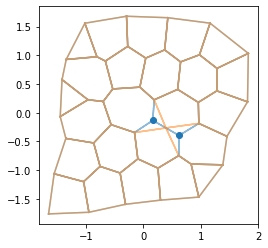

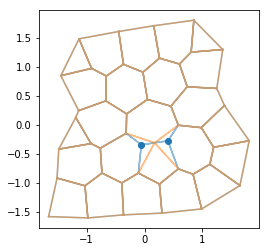

>>>>>>> remote


In [6]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
ax.scatter(sheet.edge_df.loc[center_edge, ["sx", "tx"]],
           sheet.edge_df.loc[center_edge, ["sy", "ty"]])

collapse_edge(sheet, center_edge)
sheet.update_rank()

geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

<<<<<<< local


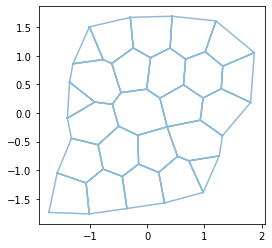

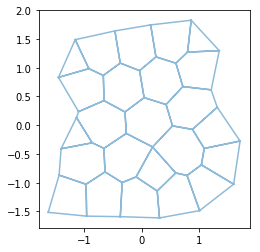

>>>>>>> remote


In [7]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


### Do it again to increase rank

Maximum vertex rank:  6


<<<<<<< local


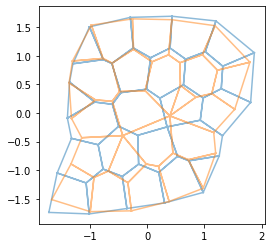

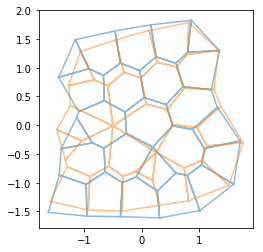

>>>>>>> remote


In [8]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

for i in range(4):
    center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
    collapse_edge(sheet, center_edge)
    geom.update_all(sheet)
    res = solver.find_energy_min(sheet, geom, model)
    sheet.update_rank()

fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})


print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

## Rosettes resolution

<hr/>

![Second screencap, solving rosettes](illus/finegan_etal_screencap2.png)

_Finegan et al. 2019_



As far as I understand, the difference between rank 5+ and rank 4 is not topological, but geometrical (the "old" vertex is moved towards the opposite cell center) and statistical because $p_4$ is higher than $p_{5+}$

### Solve for a single edge

Maximum vertex rank prior to rearangement:  6
Maximum vertex rank after rearangement:  5


<<<<<<< local


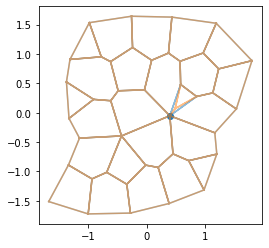

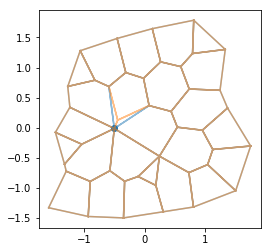

>>>>>>> remote


In [9]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].idxmax()

print("Maximum vertex rank prior to rearangement: ", sheet.vert_df['rank'].max())


fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
max_rank_vert = sheet.vert_df['rank'].idxmax()

ax.scatter(sheet.vert_df.loc[max_rank_vert, "x"],
           sheet.vert_df.loc[max_rank_vert, "y"])

sheet_split(sheet, max_rank_vert)
sheet.update_rank()

geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank after rearangement: ", sheet.vert_df['rank'].max())


<<<<<<< local


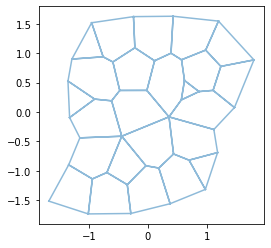

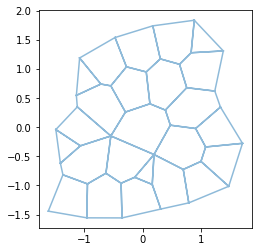

>>>>>>> remote


In [10]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

### Solve repeatedly

Maximum vertex rank prior to rearangement:  5
Maximum vertex rank:  5
Maximum vertex rank:  4
Maximum vertex rank:  4
Maximum vertex rank:  3


<<<<<<< local


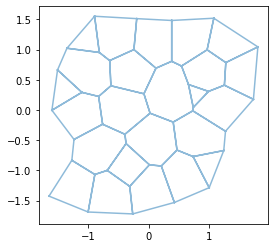

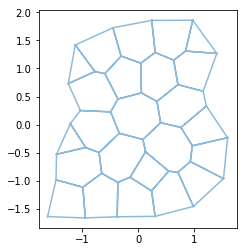

>>>>>>> remote


In [11]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].max()
print("Maximum vertex rank prior to rearangement: ", max_rank)

while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    sheet_split(sheet, max_rank_vert)
    sheet.update_rank()

    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

In [12]:
assert sheet.validate()

#### Collapse a face and resolve the rosette

In [13]:
remove_face(sheet, 12)
sheet.update_rank()
geom.update_all(sheet)

res = solver.find_energy_min(sheet, geom, model)

<<<<<<< local


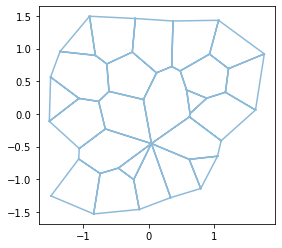

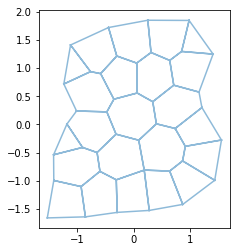

>>>>>>> remote


In [14]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


In [15]:
max_rank = sheet.vert_df['rank'].max()
while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    sheet_split(sheet, max_rank_vert)
    sheet.update_rank()

    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

<<<<<<< local


Maximum vertex rank:  3


>>>>>>> remote
<<<<<<< local <modified: >


Maximum vertex rank:  6
Maximum vertex rank:  5
Maximum vertex rank:  4
Maximum vertex rank:  3


>>>>>>> remote <removed>


<<<<<<< local


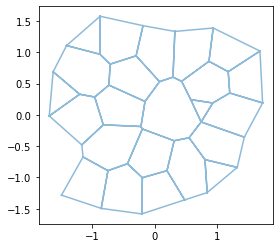

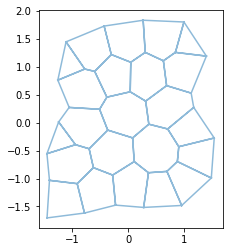

>>>>>>> remote


In [16]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

# How about in 3D?



### Illustration of the split / collapse algorithm in 3D


![illustration of the rearangements](illus/IH_transition.png)

### Extrude a monolayer from the previous sheet

In [17]:
from tyssue import MonolayerGeometry as geom

# Promote the sheet to 2.5 D
sheet.update_specs(config.geometry.sheet_spec())


specs = config.geometry.bulk_spec()
datasets = extrude(sheet.datasets, method='translation')
eptm = Monolayer('mono', datasets, specs)

geom.center(eptm)
geom.update_all(eptm) 

## Sanity check
assert eptm.validate()

### Setup a simple mechanical model and quasistatically descend it

In [18]:
model = model_factory([
    effectors.CellVolumeElasticity,
    effectors.FaceContractility,
    effectors.LineTension,
])

## Initial model settings
dyn_specs = {
    "settings": {
        "threshold_length": 1e-3,
    },
    "cell": {
        "prefered_vol": eptm.cell_df.vol.mean(),
        "prefered_area": eptm.cell_df.area.mean(),
        "vol_elasticity": 14.0,
        #"area_elasticity": 1.0,
    },
    "face": {
        #"surface_tension": 1.0,
        "contractility": 1e-2
    },
    "edge": {
        "line_tension": 0.01,
    }
}

## Those settings are set homogenously in the epithelium
eptm.update_specs(dyn_specs, reset=True)

# Lower the lateral contractility
eptm.face_df.loc[eptm.lateral_faces, 'contractility'] /= 2

solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)
eptm.update_rank()

ipv.clear()
eptm.face_df["visible"] =True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

Reseting column contractility of the face dataset with new specs
Reseting column line_tension of the edge dataset with new specs
/home/guillaume/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
<<<<<<< local


>>>>>>> remote


<<<<<<< local


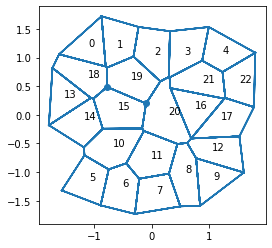

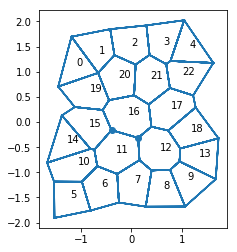

>>>>>>> remote


In [19]:
center_edge = eptm.edge_df.query('segment == "apical"').eval("sx**2 + sy**2").idxmin()

fig, ax = sheet_view(eptm, coords = ['x', 'y'], mode="quick")
for cell, (x, y) in eptm.cell_df[['x', 'y']].iterrows():
    ax.text(x, y, str(cell))
_= ax.scatter(
    eptm.edge_df.loc[center_edge, ['sx', 'tx']],
    eptm.edge_df.loc[center_edge, ['sy', 'ty']])


In [ ]:
ret_code = collapse_edge(eptm, center_edge, allow_two_sided=True)
if ret_code:
    print('Collapse failed')
geom.update_all(eptm)

eptm.update_rank()
print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

ipv.clear()
eptm.face_df["visible"] = eptm.face_df['segment'] == "lateral"
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

assert eptm.validate()


print("Maximum vertex rank: ", eptm.vert_df['rank'].max())
vert = eptm.vert_df['rank'].idxmax()
print("Rosette index: ", vert)
bck = eptm.copy()


Maximum vertex rank:  6


<<<<<<< local


>>>>>>> remote
<<<<<<< local <modified: >


Maximum vertex rank:  6
Rosette index:  7


Maximum vertex rank:  6
Rosette index:  41


>>>>>>> remote <modified: >


In [ ]:
set(condition_4ii(eptm).ravel())

set()

In [ ]:
res = solver.find_energy_min(eptm, geom, model)


In [ ]:

eptm.settings['threshold_length'] = 0.1
bulk_split(eptm, vert, face=None, multiplier=2)

assert eptm.validate()

In [ ]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

eptm.face_df["visible"] = False
#eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False
c4ii = np.unique(condition_4ii(eptm))
eptm.face_df.loc[c4ii, "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

<<<<<<< local <modified: >
/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.5.0-py3.7-linux-x86_64.egg/tyssue/utils/utils.py:150: UserWarning: Sub epithelium appears to be empty
  warnings.warn("Sub epithelium appears to be empty")
/home/guillaume/miniconda3/lib/python3.7/site-packages/tyssue-0.5.0-py3.7-linux-x86_64.egg/tyssue/utils/utils.py:150: UserWarning: Sub epithelium appears to be empty
  warnings.warn("Sub epithelium appears to be empty")
>>>>>>> remote <modified: >
<<<<<<< local


>>>>>>> remote


## Testing vertex split towards all possible faces

In [25]:
all_edges = bck.edge_df[
    (bck.edge_df["trgt"] == vert)
    | (bck.edge_df["srce"] == vert)
]


eptms = {}
for face, edge in all_edges.reset_index().groupby("face").first()['edge'].items():
    eptm = bck.copy()
    cell = eptm.edge_df.loc[edge, "cell"]
    print(f"splitting vertex {vert} towards cell {cell} over face {face}")
    bulk_split(eptm, vert, face=face, multiplier=2)
    assert eptm.validate()
    c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
    if len(c4i):
        print(f"\nIssue with face {face}")
        print("Number of condition 4i faces : ", len(c4i))
    if len(c4ii):
        print(f"\nIssue with face {face}")
        print("Number of condition 4ii faces : ", len(c4ii))
    
    eptms[face] = eptm


<<<<<<< local


splitting vertex 7 towards cell 15 over face 15
splitting vertex 7 towards cell 18 over face 18
splitting vertex 7 towards cell 19 over face 19
splitting vertex 7 towards cell 20 over face 20
splitting vertex 7 towards cell 15 over face 89
splitting vertex 7 towards cell 18 over face 90
splitting vertex 7 towards cell 18 over face 91
splitting vertex 7 towards cell 19 over face 92
splitting vertex 7 towards cell 19 over face 97
splitting vertex 7 towards cell 15 over face 98
splitting vertex 7 towards cell 19 over face 101
splitting vertex 7 towards cell 20 over face 102
splitting vertex 7 towards cell 20 over face 128
splitting vertex 7 towards cell 15 over face 129


splitting vertex 41 towards cell 11 over face 11
splitting vertex 41 towards cell 12 over face 12
splitting vertex 41 towards cell 15 over face 15
splitting vertex 41 towards cell 16 over face 16
splitting vertex 41 towards cell 16 over face 113
splitting vertex 41 towards cell 11 over face 114
splitting vertex 41 towards cell 16 over face 128
splitting vertex 41 towards cell 12 over face 129
splitting vertex 41 towards cell 15 over face 153
splitting vertex 41 towards cell 16 over face 154
splitting vertex 41 towards cell 15 over face 155
splitting vertex 41 towards cell 11 over face 156
splitting vertex 41 towards cell 11 over face 157
splitting vertex 41 towards cell 12 over face 158


>>>>>>> remote


In [26]:
ipv.clear()
geom.update_all(eptm)

eptm.face_df["visible"] = False
#eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

<<<<<<< local


>>>>>>> remote


### Collapsing a face

In [27]:
eptm.vert_df['rank'].min()

3

In [28]:
condition_4ii(eptm)

array([], shape=(0, 2), dtype=int64)

In [29]:
center_face = eptm.face_df.query("segment == 'apical'").eval("x**2 + y**2").idxmin()

remove_face(eptm, center_face)

0

In [30]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

<<<<<<< local


>>>>>>> remote


### Split the created vertex

In [31]:
vert = eptm.vert_df.index[-1]

bulk_split(eptm, vert)


geom.update_all(eptm)

assert eptm.validate()

In [32]:
ipv.clear()
geom.update_all(eptm)
res = solver.find_energy_min(eptm, geom, model)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

<<<<<<< local


>>>>>>> remote


In [33]:
eptm.update_rank()

print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

vert = eptm.vert_df['rank'].idxmax()
print("Rosette index: ", vert)

<<<<<<< local <modified: >


Maximum vertex rank:  21
Rosette index:  78


Maximum vertex rank:  12
Rosette index:  83


>>>>>>> remote <modified: >


### Solve repeatedly

In [ ]:
from itertools import count

In [39]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
for i in count():
    vert = eptm.vert_df['rank'].idxmax()
<<<<<<< local
    try:
        bulk_split(eptm, vert)
    except ValueError:
        continue
=======
    bulk_split(eptm, vert)
>>>>>>> remote
    eptm.update_rank()
    max_rank = eptm.vert_df['rank'].max()
    print("Maximum vertex rank: ", max_rank)
    
    geom.update_all(eptm)
    res = solver.find_energy_min(eptm, geom, model)
    assert eptm.validate()
    if max_rank < 5:
        break
    
    elif i > 100:
        raise RecursionError
    

<<<<<<< local


Maximum vertex rank:  17
Maximum vertex rank:  15
Maximum vertex rank:  13
Maximum vertex rank:  11
Maximum vertex rank:  9
Maximum vertex rank:  7
Maximum vertex rank:  5
Maximum vertex rank:  4


Maximum vertex rank:  10
Maximum vertex rank:  8
Maximum vertex rank:  6
Maximum vertex rank:  4


>>>>>>> remote


In [ ]:
ipv.clear()
geom.update_all(eptm)

#eptm.face_df["visible"] = False
eptm.face_df["visible"] = eptm.face_df["segment"] == "lateral"
#eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + (y+0.5)**2) < 0.5')
#eptm.face_df["visible"] = False

#eptm.face_df.loc[set(condition_4ii(eptm).ravel()[:2]), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)

ipv.show()

<<<<<<< local


>>>>>>> remote
